In [2]:
from pathlib import Path
import importlib
import requests
import numpy as np
from matplotlib import pyplot as plt
from pymol import cmd
from pymol import util
from typing import Literal
from numpy.typing import NDArray, ArrayLike
from overprot.libs import lib_structure
from overprot.libs import lib_pymol

for module in [lib_structure, lib_pymol]: 
    importlib.reload(module)

In [3]:
DATA = Path('/home/adam/Workspace/Python/OverProt/data/smoothing')
# DATA_STRUCTS = DATA / 'structs'
DATA_STRUCTS = DATA / 'consensus_cif'
# DATA_IMAGES = DATA / 'images'
DATA_IMAGES = DATA / 'images_consensus'
URL_STRUCT_SOURCE = 'http://www.ebi.ac.uk/pdbe/entry-files/download/{pdb}_updated.cif'

def get_pdb_struct(pdb: str) -> lib_structure.Structure:
    file = DATA_STRUCTS / f'{pdb}.cif'
    if not Path.is_file(file):
        file.parent.mkdir(exist_ok=True, parents=True)
        cif_bytes = requests.get(URL_STRUCT_SOURCE.format(pdb=pdb)).content
        file.write_bytes(cif_bytes)
    return lib_pymol.read_cif(file)

In [122]:
CUT_THRESHOLD = 8
# DEFAULT_PROFILE_7 = [1,2,3,4,3,2,1]
# DEFAULT_PROFILE = [0.10650551, 0.25, 0.28698898, 0.25, 0.10650551]
DEFAULT_PROFILE = (6980/2**16, 16384/2**16, 18808/2**16, 16384/2**16, 6980/2**16)

def _smooth_chunk(coords: NDArray, *, profile: list[float], ends: Literal['trim', 'original', 'mirror', 'straight'], out: NDArray) -> None:
    '''Smooth a sequence of N points `coords` (shape (3, N)) by convolution with `profile` (shape (k,)). Save the result in `out`.
    `ends` controls the dealing with first and last points, which don't have enough neighbors to calculate convolution
    ('trim' shortens the sequence to (3, N-k+1); 'original' keeps unsmoothed coordinates, 'straight' interpolates to keep the shape (3, N)).
    If the sequence is too short to smooth, keep unsmoothed coordinates.'''
    n_points = coords.shape[1]
    k = len(profile)
    assert k % 2 == 1, 'length of the profile must be odd'
    kk = k // 2
    if ends == 'trim':
        assert n_points >= k
        out[:, :] = 0
        for i in range(k):
            out += profile[i] * coords[:, i: -2*kk+i or None]
        sum_profile = sum(profile)
        if sum_profile != 1.0:
            out /= sum_profile
            raise
    else:
        min_length = k if ends=='original' else k+kk if ends=='mirror' else k+1
        if n_points < min_length:
            out[:, :] = coords
            return
        _smooth_chunk(coords, profile=profile, ends='trim', out=out[:, kk:-kk])
        if ends == 'original':
            out[:, :kk] = coords[:, :kk]
            out[:, -kk:] = coords[:, -kk:]
        elif ends == 'mirror':
            out[:, :kk] = 2*out[:, kk:kk+1] - out[:, 2*kk:kk:-1]
            out[:, -kk:] = 2*out[:, -kk-1:-kk] - out[:, -kk-2:-2*kk-2:-1]
        elif ends == 'straight':
            start = out[:, kk]
            startstep = start - out[:, kk+1]
            end = out[:, -kk-1]
            endstep = end - out[:, -kk-2]
            out[:, :kk] = start.reshape((-1, 1)) + startstep.reshape((-1, 1)) * np.arange(kk, 0, -1).reshape((1, -1))
            out[:, -kk:] = end.reshape((-1, 1)) + endstep.reshape((-1, 1)) * np.arange(1, kk+1).reshape((1, -1))
        else: 
            raise NotImplementedError()

def smooth(coords: NDArray, *, profile: list[float]=DEFAULT_PROFILE, ends: Literal['original', 'mirror', 'straight'] = 'straight', cut_threshold: float = np.inf, out: NDArray = None) -> NDArray:
    '''Cut a sequence of N points `coords` (shape (3, N)) into chunks (cut where point distance is above cut_threshold).
    Then apply smoothing to each chunk. Meaning of `ends` - see _smooth_chunk.
    '''
    n_points = coords.shape[1]
    if cut_threshold == np.inf:
        offsets = [0, n_points]
    else:
        offsets = cut_chain(coords, cut_threshold)
    n_chunks = len(offsets) - 1
    k = len(profile)
    if out is None:
        out = np.empty_like(coords)
    for i in range(n_chunks):
        fro, to = offsets[i], offsets[i+1]
        _smooth_chunk(coords[:, fro:to], profile=profile, ends=ends, out=out[:, fro:to])
    return out
        
def roughness(coords: NDArray) -> NDArray:
    avg = (coords[:,:-2] + coords[:,2:])/2
    diff = coords[:,1:-1] - avg
    return np.sqrt(np.sum(diff**2, axis=0))

def running_distance(coords: NDArray) -> NDArray:
    diff = coords[:,1:] - coords[:,:-1]
    return np.sqrt(np.sum(diff**2, axis=0))

def cut_chain(coords: NDArray, distance_threshold = 8) -> NDArray:
    '''Return indices where the chain should be cut, e.g. [0 5 8 12] means "cut to [0 1 2 3 4], [5 6 7], [8 9 10 11]".'''
    dist = running_distance(coords)
    cut_indices = np.where(dist > distance_threshold)[0]
    offsets = np.hstack([[0], cut_indices+1, [coords.shape[1]]])
    return offsets

def make_smoothed_cif_images(pdbid: str) -> None:
    DATA_IMAGES.mkdir(exist_ok=True, parents=True)
    try: 
        cmd.load(DATA_STRUCTS/f'{pdbid}.cif', 'obj_orig')
        cmd.select('orig', 'obj_orig and name CA')
        cmd.load(DATA_STRUCTS/f'{pdbid}.smooth.cif', 'smooth')
        util.chainbow('orig')
        util.chainbow('smooth')
        cmd.set('cartoon_trace_atoms', 1)  # avoid dashed connections
        cmd.set('sphere_scale', 0.2)  # avoid dashed connections
        cmd.cartoon('loop')
        cmd.orient('orig')
        cmd.hide()
        cmd.show('cartoon', 'orig')
        cmd.show('spheres', 'orig')
        cmd.ray(1000,1000)
        cmd.save(DATA_IMAGES / f'{pdbid}-orig.png')
        cmd.hide()
        cmd.show('cartoon', 'smooth')
        cmd.show('spheres', 'smooth')
        cmd.ray(1000,1000)
        cmd.save(DATA_IMAGES / f'{pdbid}-smooth.png')
        cmd.color('gray60', 'orig')
        cmd.show('cartoon', 'orig')
        cmd.show('spheres', 'orig')
        cmd.ray(1000, 1000)
        cmd.save(DATA_IMAGES / f'{pdbid}-smooth+orig.png')
    finally:
        cmd.delete('all')

def make_smoothed_cifs(*pdbids: str, make_images: bool = False, profile=DEFAULT_PROFILE, cut_threshold=CUT_THRESHOLD) -> None:
    for pdbid in pdbids:
        struct = get_pdb_struct(pdbid)
        trace = struct.get_alpha_trace()
        A = trace.coords
        B = smooth(A, profile=profile, cut_threshold=cut_threshold)
        n = B.shape[1]
        smoothed = lib_structure.Structure(symbol=trace.symbol, name=trace.name, resn=trace.resn, resi=trace.resi,
            chain = np.full(n, 'X'), auth_chain=np.full(n, 'X'), entity=trace.entity, coords=B)
        smoothed.save_cif(DATA_STRUCTS / f'{pdbid}.smooth.cif')
        if make_images:
            make_smoothed_cif_images(pdbid)


def overview(*pdbids: str) -> None:
    for pdbid in pdbids:
        struct = get_pdb_struct(pdbid).get_alpha_trace()
        A = struct.coords
        Bsm5 = smooth(A, cut_threshold=CUT_THRESHOLD)

        print(pdbid)
        print('Min distance:', running_distance(A).min(), f'({struct.resi[np.argmin(running_distance(A))]})')
        print('Max distance:', running_distance(A).max(), f'({struct.resi[np.argmax(running_distance(A))]})')
        print('Median distance:', np.median(running_distance(A)), np.median(running_distance(Bsm5)))
        print('Mean roughness:', roughness(A).mean(), roughness(Bsm5)[3:-3].mean())
        
        fig, subplts = plt.subplot_mosaic([['coords', 'dist'], ['coords', 'rough']], gridspec_kw={'width_ratios':[1, 2]}, figsize=(28,9))
        pltC, pltD, pltR = subplts['coords'], subplts['dist'], subplts['rough']
        dx, dy = 0, 1
        pltC.set_title(pdbid)
        pltC.plot(A[dx], A[dy], 'r.-', label='original')
        pltC.plot(Bsm5[dx], Bsm5[dy], 'k.-', label='smooth(smart5)')
        pltC.legend()
        pltC.axis('equal')

        minresi, maxresi = struct.resi.min(), struct.resi.max()

        pltD.set_title('Running distance')
        pltD.plot(struct.resi[:-1], running_distance(A), 'r')
        pltD.plot(struct.resi[:-1], running_distance(Bsm5), 'k')
        pltD.axis(xmin=minresi, xmax=maxresi, ymin=0, ymax=running_distance(A).max())

        pltR.set_title('Roughness')
        pltR.plot(struct.resi[1:-1], roughness(A), 'r')
        pltR.plot(struct.resi[1:-1], roughness(Bsm5), 'k')
        pltR.axis(xmin=minresi, xmax=maxresi, ymin=0, ymax=roughness(A).max())
        plt.show()

def has_resi_skips(struct) -> bool:
    skip = struct.resi[1:] - struct.resi[:-1] - 1 
    return np.any(skip != 0)


In [62]:
# structures = ['1tqn', '5zim', '1cbs', '1mpf', 'consensus-cyp', 'consensus-1.10.10.1020', 'consensus-immunoglobulin', 'consensus-lipocalin']
structures = Path(DATA/'consensus_list_100.txt').read_text().split()
structures_all = Path(DATA/'consensus_list.txt').read_text().split()

In [127]:
# Calculating smart profile of length 5 (should nicely smooth 3.6-helix and 2.0-helix)
A = np.array([[1, 2, 2], [1, -2, 2], [1, 2*np.cos(np.pi/1.8), 2*np.cos(2*np.pi/1.8)]])
b = [1, 0, 0]
x = np.linalg.solve(A, b)
y = np.array([x[2], x[1], x[0], x[1], x[2]])
x, y

(array([0.28698898, 0.25      , 0.10650551]),
 array([0.10650551, 0.25      , 0.28698898, 0.25      , 0.10650551]))

In [129]:
y.sum() - 1

0.0

In [118]:
I = 2**16
x = np.array(DEFAULT_PROFILE)*I
y = x.round().astype(int)
z = y / I
DEFAULT_PROFILE, x, y, z, sum(z), 1/I

([0.10650551, 0.25, 0.28698898, 0.25, 0.10650551],
 array([ 6979.94510336, 16384.        , 18808.10979328, 16384.        ,
         6979.94510336]),
 array([ 6980, 16384, 18808, 16384,  6980]),
 array([0.10650635, 0.25      , 0.2869873 , 0.25      , 0.10650635]),
 1.0,
 1.52587890625e-05)

In [123]:
#12221
(2*0 + 2*2*1 + 2*1*2) / (2 + 2*2 + 2*1)
(0 + 2*0.3885*1 + 2*0.16551*2) / (0.445985 + 2*0.3885 + 2*0.16551)
# [0.28698898, 0.25, 0.10650551]
(0 + 2*0.25*1 + 2*0.10650551*2) / (0.28698898 + 2*0.25 + 2*0.10650551)

0.92602204

consensus-1.10.10.1510
Min distance: 3.718036 (60)
Max distance: 3.8725731 (49)
Median distance: 3.8118773 1.804735
Mean roughness: 2.355661 0.36304483


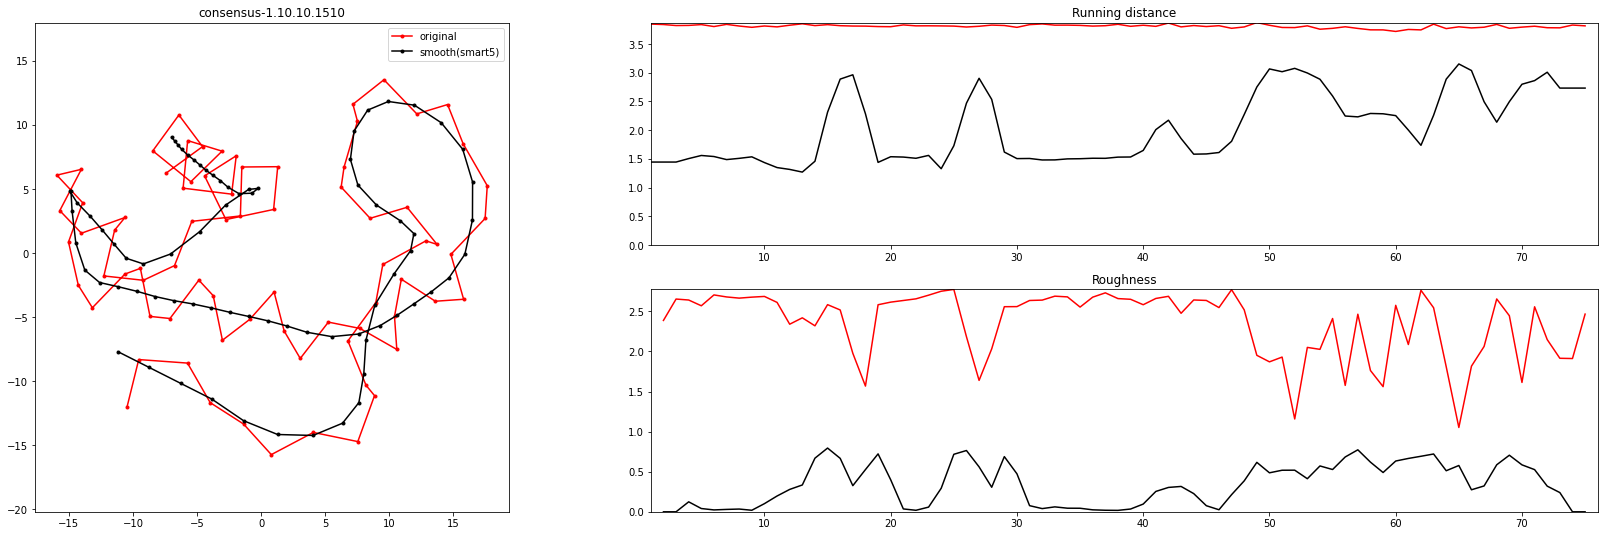

consensus-3.90.660.20
Min distance: 1.9856867 (45)
Max distance: 35.13312 (58)
Median distance: 3.7721467 2.6109033
Mean roughness: 2.3658395 0.77551734


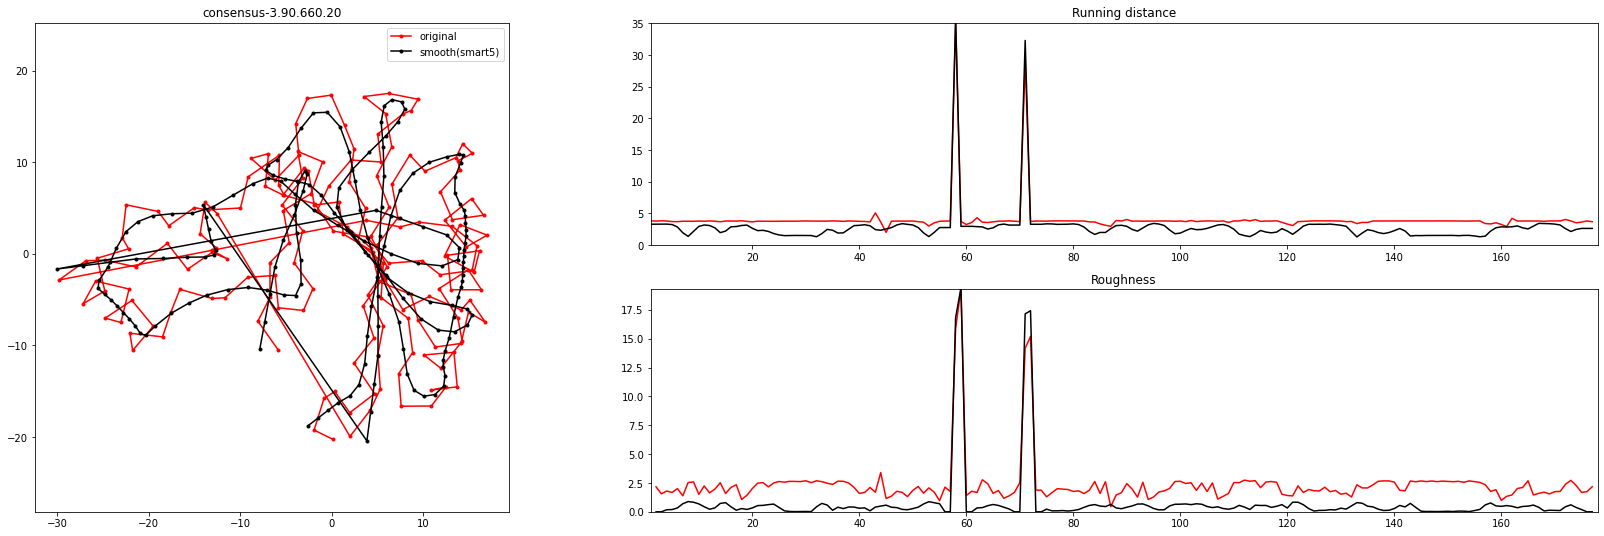

consensus-3.30.70.3150
Min distance: 2.7970474 (36)
Max distance: 12.134873 (58)
Median distance: 3.7132819 1.9056898
Mean roughness: 2.523395 0.48565772


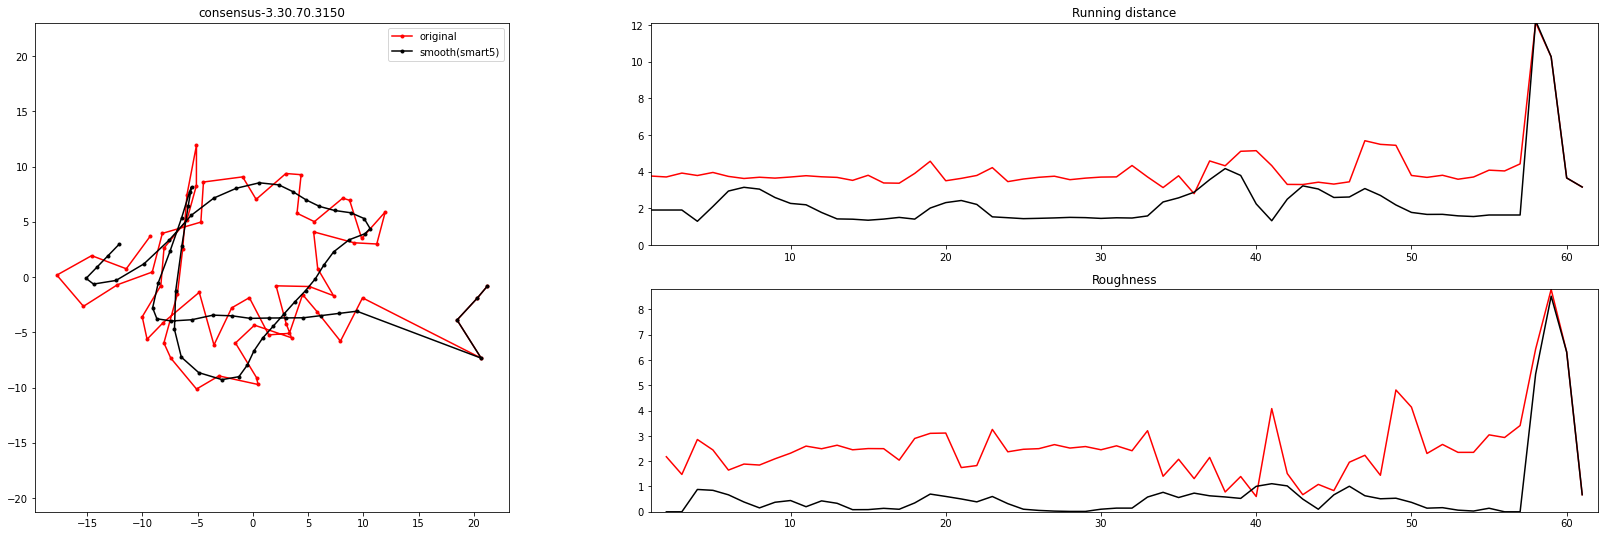

In [124]:
overview(structures[0], 'consensus-3.90.660.20', structures[70])
# The best smoothing profile is 1234321 (tried also 11111, 12221, 1111111, 1112111, 1233321, SavGol5, SavGol7)
# But 12221 is maybe better for cartoon visualization (pulls loops less tight) 
# TODO find chain-cut threshold (~7? or more?)
# TODO use smooth trace in overprot 3D image
# TODO try showing smooth trace of superimposed family members

In [8]:
any(has_resi_skips(get_pdb_struct(s)) for s in structures_all)

In [14]:
distl = []
for s in structures:
    struct = get_pdb_struct(s).get_only_polymer()
    distl.append(running_distance(struct.coords))
dists = np.hstack(distl)
print(len(distl), dists.shape)

100 (12642,)


In [15]:
np.sum(dists >= 7.5) / len(dists)

0.0036386647682328747

In [16]:
def print_skips(min_d: float, max_d: float) -> None:
    with_skips = []
    for s, d in zip(structures, distl):
        if min_d < d.max() < max_d:
            with_skips.append((s, d.max(), d.argmax()))
    print(f'{min_d}-{max_d}: {len(with_skips)}', *with_skips, sep='\n')
print_skips(8, np.inf)
# SKIP_THRESHOLD = 8

8-inf: 27
('consensus-1.10.3210.40', 13.157, 190)
('consensus-1.10.3210.50', 10.715057, 49)
('consensus-1.10.3290.20', 8.190563, 93)
('consensus-1.10.3450.40', 13.834431, 41)
('consensus-1.10.357.170', 11.586928, 115)
('consensus-1.20.1050.20', 14.391528, 46)
('consensus-1.20.1270.420', 12.737609, 75)
('consensus-1.25.40.1040', 11.052066, 148)
('consensus-2.30.34.10', 11.853951, 37)
('consensus-2.30.36.90', 21.566755, 14)
('consensus-2.40.30.30', 16.044949, 6)
('consensus-2.40.37.30', 15.053881, 92)
('consensus-2.40.50.250', 23.171682, 64)
('consensus-2.60.120.680', 11.445839, 46)
('consensus-2.60.120.690', 25.324224, 118)
('consensus-2.60.470.10', 13.007614, 22)
('consensus-2.70.98.110', 12.990521, 227)
('consensus-3.30.450.390', 22.185339, 23)
('consensus-3.30.70.3150', 12.134873, 57)
('consensus-3.40.210.20', 24.978989, 67)
('consensus-3.40.50.1360', 9.635963, 120)
('consensus-3.40.50.620', 10.659027, 64)
('consensus-3.50.100.10', 17.566107, 51)
('consensus-3.90.1680.10', 13.550154,

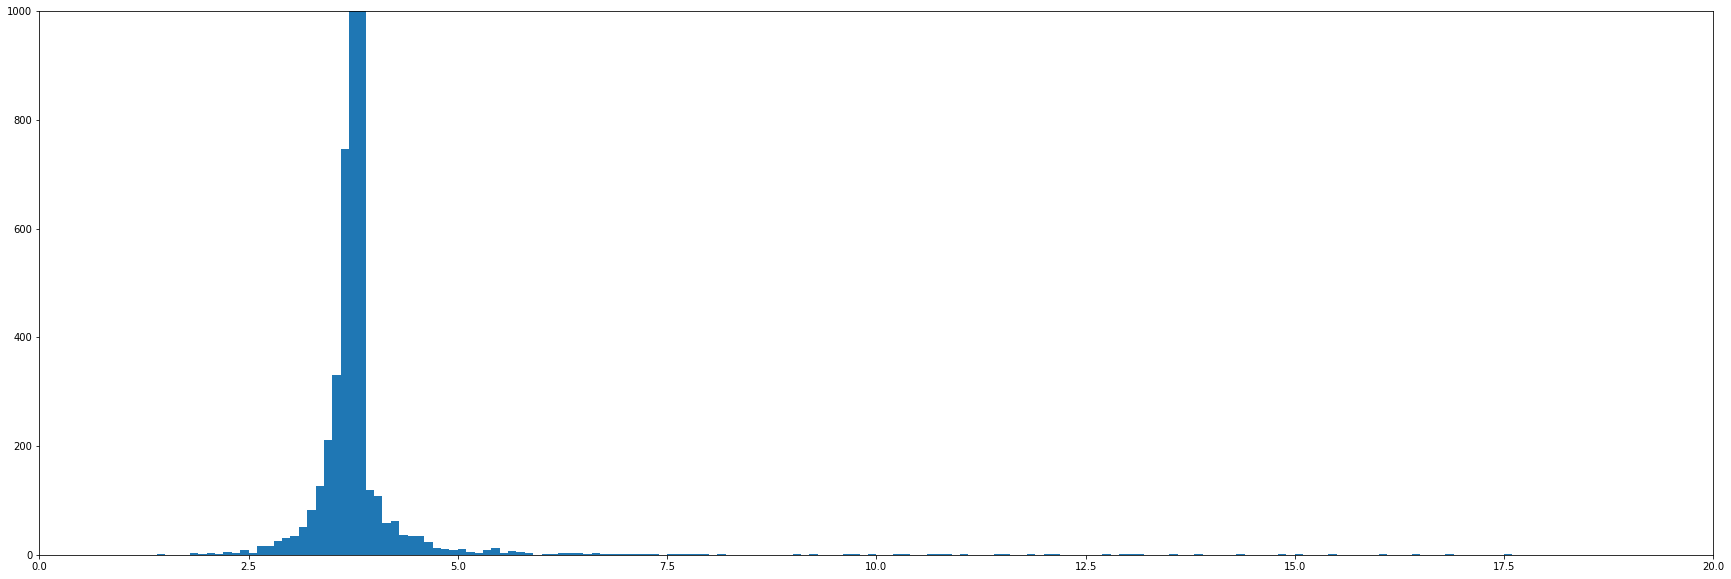

In [52]:
plt.figure(figsize=(30, 10))
plt.hist(dists, bins=np.arange(0, 35, 0.1))
plt.axis(xmin=0, xmax=20)
plt.axis(ymin=0, ymax=1000)
plt.show()

In [91]:
make_smoothed_cifs(*structures, make_images=True, cut_threshold=CUT_THRESHOLD, profile=SMART_PROFILE)

In [51]:

def fdecor(f: Func):
    print(f.__name__)
    return f

@fdecor
def foo():
    print('x')

foo()

foo
x
